Excel Dosyasını Okuma

In [1]:
import pandas as pd

file_path = "intents.xlsx"  
df = pd.read_excel(file_path)

Her Satırı Document Nesnesine Dönüştürme

In [2]:
from langchain_core.documents import Document

docs = []
for idx, row in df.iterrows():
    content = row["kullanici_soru"]
    metadata = {"intent": row["intent_basligi"], "row_id": idx}
    doc = Document(page_content=content, metadata=metadata)
    docs.append(doc)

print("Toplam belge:", len(docs))

Toplam belge: 1000


Veriyi Test ve Eğitim Verisi Olarak Bölme

In [3]:
from sklearn.model_selection import train_test_split

# Rastgele eğitim ve test verisi olarak bölme
train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=42)

# Eğitim ve test veri setlerinin uzunluğunu kontrol etme
print("Eğitim verisi uzunluğu:", len(train_docs))
print("Test verisi uzunluğu:", len(test_docs))

Eğitim verisi uzunluğu: 800
Test verisi uzunluğu: 200


In [32]:
train_docs[25]

Document(metadata={'intent': 'restoran_kafe', 'row_id': 2}, page_content='Deniz ürünleriyle ünlü restoranlar nerede bulunur?')

Google Generative AI Embeddings'i kullanarak Embedding Oluşturma İşlemi

In [33]:
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv

In [34]:
load_dotenv()

True

In [35]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vector = embeddings.embed_query("hello, world!")
vector[:5]

[0.05168594419956207,
 -0.030764883384108543,
 -0.03062233328819275,
 -0.02802734263241291,
 0.01813093200325966]

ChromaDB Üzerine Kayıt İşlemi

In [36]:
vectorstore = Chroma.from_documents(documents=train_docs, embedding=embeddings,persist_directory="./chroma_db")

In [37]:
retriever = vectorstore.as_retriever(
    search_type="similarity", search_kwargs={"k":4}
)

In [38]:
retieved_docs = retriever.invoke("merhaba")

In [39]:
len(retieved_docs)

4

In [40]:
print(retieved_docs[3].page_content)

Merhaba, ben hazırım  


Google Gemini API Yapısını Kullanarak LLM Tetikleme İşlemleri

In [41]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.3,
    max_tokens=500)

In [42]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

In [43]:
system_prompt = (
    "Sen, turistlere rehberlik eden bir chatbot'sun."
    "Aşağıda verilen bağlamlara göre en uygun cevabı ver."
    "Yanıtlarını mümkün olduğunca kısa ve net tut, üç cümleyi geçmemeye çalış. "
    "Eğer cevabı bilmiyorsan 'Bilmiyorum' diye belirt."
    "\n\n{context}"
)

In [44]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system_prompt),
        ("human","{input}")
    ]
)

Soru-Cevap Zinciri Oluşturma(LLM+PROMPT)

In [45]:
question_answer_chain = create_stuff_documents_chain(llm,prompt)

RAG Zinciri Oluşturma(RAG+LLM Entegrasyonun Gerçekleşmesi)

In [46]:
rag_chain = create_retrieval_chain(retriever,question_answer_chain)

Kullanıcı Sorgusunu Çaıştırarak Cevap Üretme İşlemi

In [ ]:
response = rag_chain.invoke({"input":"Fransa Pariste şehrin merkezine yakın otel önerir misin?"})

In [48]:
print(response)

{'input': "Fransa Paris'te şehrin merkezine yakın otel önerir misin?", 'context': [Document(metadata={'intent': 'konaklama', 'row_id': 311}, page_content='Şehir merkezine yakın otel var mı?'), Document(metadata={'intent': 'konaklama', 'row_id': 311}, page_content='Şehir merkezine yakın otel var mı?'), Document(metadata={'intent': 'konaklama', 'row_id': 311}, page_content='Şehir merkezine yakın otel var mı?'), Document(metadata={'intent': 'konaklama', 'row_id': 311}, page_content='Şehir merkezine yakın otel var mı?')], 'answer': "Evet, Paris'te şehir merkezine yakın birçok otel bulunmaktadır. Örneğin, Louvre Müzesi ve Notre Dame Katedrali gibi turistik yerlere yürüme mesafesinde olan Hotel Saint-André des Arts veya Hotel Saint-Paul Rive Gauche'u düşünebilirsiniz. Bütçenize ve tercihlerinize uygun daha fazla seçenek için online seyahat sitelerine göz atabilirsiniz."}


PERFORMANS METRİKLERİ

In [50]:
import time
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

def extract_predicted_intent(chatbot_response):
    intents = [doc.metadata['intent'] for doc in chatbot_response['context']]
    most_common_intent, _ = Counter(intents).most_common(1)[0]
    return most_common_intent

y_true = []
y_pred = []

for idx, doc in enumerate(test_docs):
    question = doc.page_content
    true_intent = doc.metadata['intent']
    
    chatbot_response = rag_chain.invoke({"input": question})
    predicted_intent = extract_predicted_intent(chatbot_response)
    
    y_true.append(true_intent)
    y_pred.append(predicted_intent)
    
    # Her çağrıdan sonra 5 saniye bekle
    time.sleep(5)


    if (idx + 1) % 10 == 0:
        print(f"{idx + 1} soru işlendi")

print("Doğruluk (Accuracy):", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

10 soru işlendi
20 soru işlendi
30 soru işlendi
40 soru işlendi
50 soru işlendi
60 soru işlendi
70 soru işlendi
80 soru işlendi
90 soru işlendi
100 soru işlendi
110 soru işlendi
120 soru işlendi
130 soru işlendi
140 soru işlendi
150 soru işlendi
160 soru işlendi
170 soru işlendi
180 soru işlendi
190 soru işlendi
200 soru işlendi
Doğruluk (Accuracy): 0.65
                  precision    recall  f1-score   support

     acil_yardim       0.53      0.62      0.57        13
   doviz_bilgisi       0.70      0.56      0.62        25
     etkinlikler       0.48      0.73      0.58        15
gezilecek_yerler       0.69      0.41      0.51        27
     hava_durumu       0.68      0.68      0.68        22
       konaklama       0.86      0.86      0.86        21
   restoran_kafe       0.89      0.40      0.55        20
      selamlasma       1.00      0.73      0.84        11
          ulasim       0.37      1.00      0.54        13
       vedalasma       1.00      0.70      0.82        10
vize

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
report = classification_report(y_true, y_pred, zero_division=0) 

print(report)  


print("Doğruluk (Accuracy):", accuracy_score(y_true, y_pred))
print("Kesinlik (Precision):", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Duyarlılık (Recall):", recall_score(y_true, y_pred, average='weighted', zero_division=0))
print("F1 Skoru (F1-Score):", f1_score(y_true, y_pred, average='weighted', zero_division=0))


                  precision    recall  f1-score   support

     acil_yardim       0.53      0.62      0.57        13
   doviz_bilgisi       0.70      0.56      0.62        25
     etkinlikler       0.48      0.73      0.58        15
gezilecek_yerler       0.69      0.41      0.51        27
     hava_durumu       0.68      0.68      0.68        22
       konaklama       0.86      0.86      0.86        21
   restoran_kafe       0.89      0.40      0.55        20
      selamlasma       1.00      0.73      0.84        11
          ulasim       0.37      1.00      0.54        13
       vedalasma       1.00      0.70      0.82        10
vize_ve_belgeler       0.71      0.74      0.72        23

        accuracy                           0.65       200
       macro avg       0.72      0.67      0.66       200
    weighted avg       0.72      0.65      0.65       200

Doğruluk (Accuracy): 0.65
Kesinlik (Precision): 0.7153388112491373
Duyarlılık (Recall): 0.65
F1 Skoru (F1-Score): 0.65347595154

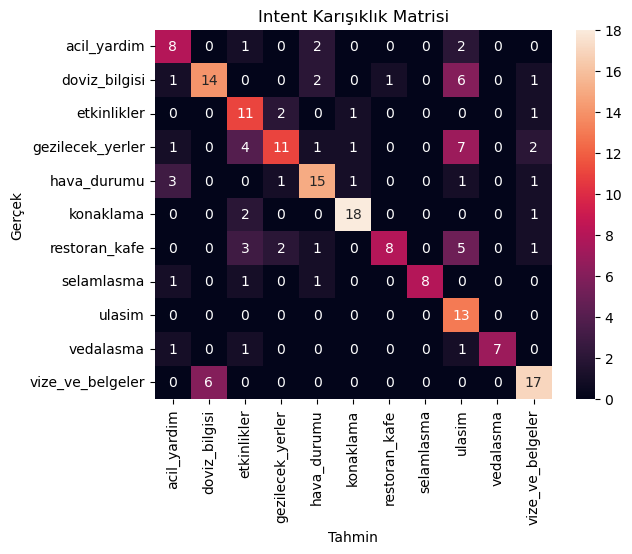

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Intent Karışıklık Matrisi')
plt.show()